In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import xgboost
data_fruit = pd.read_csv("quotes2.csv")
data_fruit = data_fruit[data_fruit["Quality"].notna()]
data_fruit['Acidity'] = data_fruit['Acidity'].astype(float).round(6)

data_fruit['Density'] = data_fruit['Weight'] / data_fruit['Size']

minmax_scaler = MinMaxScaler()
data_fruit['juiciness_scaled'] = minmax_scaler.fit_transform(data_fruit[['Juiciness']])
data_fruit['ripeness_scaled'] = minmax_scaler.fit_transform(data_fruit[['Ripeness']])
data_fruit['acidity_scaled'] = minmax_scaler.fit_transform(data_fruit[['Acidity']])
data_fruit['size_scaled'] = minmax_scaler.fit_transform(data_fruit[['Size']])
data_fruit['weight_scaled'] = minmax_scaler.fit_transform(data_fruit[['Weight']])
data_fruit['sweetness_scaled'] = minmax_scaler.fit_transform(data_fruit[['Sweetness']])
data_fruit['crunchiness_scaled'] = minmax_scaler.fit_transform(data_fruit[['Crunchiness']])

data_fruit = data_fruit.drop('A_id', axis=1)

data_fruit.to_csv("quotes3.csv", index=False)

In [19]:
features = [
    'size_scaled', 
    'weight_scaled',
    'sweetness_scaled',
    'crunchiness_scaled',
    'juiciness_scaled',
    'ripeness_scaled',
    'acidity_scaled', 
]

X = data_fruit[features]

y = data_fruit['Quality'].map({'good': 1, 'bad': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

model = xgboost.XGBClassifier(
    learning_rate=0.02,
    subsample=0.2,
    colsample_bytree=0.5,
    n_estimators=5000,
    random_state=42,
    base_score=y_train.mean(),
    n_jobs=-1
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)



[0]	validation_0-logloss:0.69008
[1]	validation_0-logloss:0.68448
[2]	validation_0-logloss:0.68098
[3]	validation_0-logloss:0.67665
[4]	validation_0-logloss:0.67271
[5]	validation_0-logloss:0.66796
[6]	validation_0-logloss:0.66420
[7]	validation_0-logloss:0.65944
[8]	validation_0-logloss:0.65546
[9]	validation_0-logloss:0.65200
[10]	validation_0-logloss:0.64792
[11]	validation_0-logloss:0.64514
[12]	validation_0-logloss:0.64191
[13]	validation_0-logloss:0.63848
[14]	validation_0-logloss:0.63469
[15]	validation_0-logloss:0.63150
[16]	validation_0-logloss:0.62709
[17]	validation_0-logloss:0.62510
[18]	validation_0-logloss:0.62018
[19]	validation_0-logloss:0.61699
[20]	validation_0-logloss:0.61343
[21]	validation_0-logloss:0.61020
[22]	validation_0-logloss:0.60709
[23]	validation_0-logloss:0.60506
[24]	validation_0-logloss:0.60183
[25]	validation_0-logloss:0.59890
[26]	validation_0-logloss:0.59602
[27]	validation_0-logloss:0.59240
[28]	validation_0-logloss:0.59023
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,0.5009375
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [4]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)

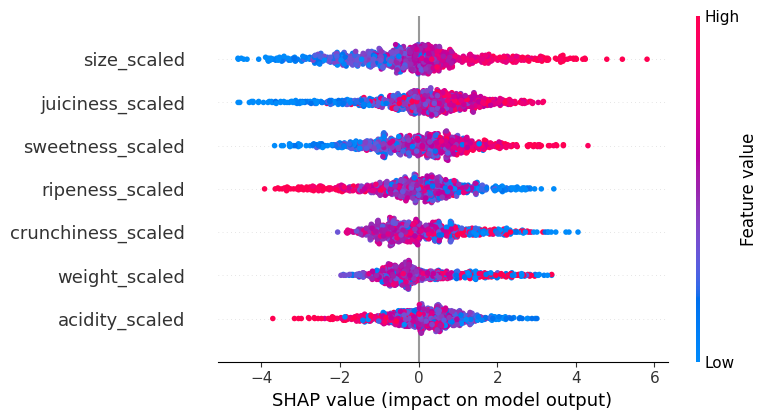

In [5]:
shap.summary_plot(shap_values, X_test)

In [20]:
y_pred = model.predict(X_test)
print("\nТестовая accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred))
# print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred))


Тестовая accuracy: 0.89125
Test F1-score: 0.8921933085501859
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       399
           1       0.89      0.90      0.89       401

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



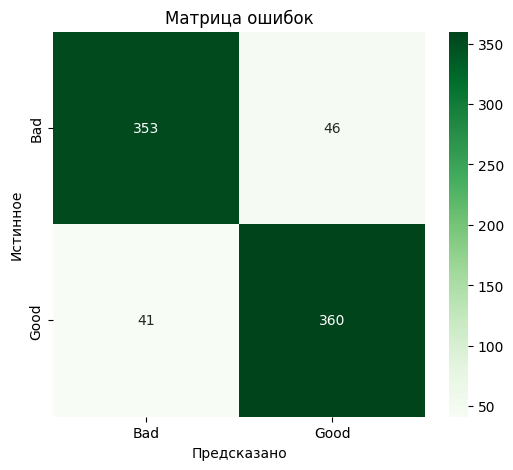

In [21]:
final_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(final_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel("Предсказано")
plt.ylabel("Истинное")
plt.title("Матрица ошибок")
plt.show()

In [22]:
from skops.io import dump
import json

# 3. Сохраняем метрики
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
pd.DataFrame([metrics]).to_csv('metrics.csv', index=False)

# 4. Сохраняем тестовые данные для визуализации
test_data = {
    "X_test": X_test.to_dict(orient='list'),
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
}

with open('test_data.json', 'w', encoding='utf-8') as f:
    json.dump(test_data, f, indent=4)


In [ ]:
import joblib

joblib.dump(model, 'apple_quality_model.pkl', protocol=4)

import json

model_metadata = {
    "features": features,
    "metrics": {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    }
}

with open('model_metadata2.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

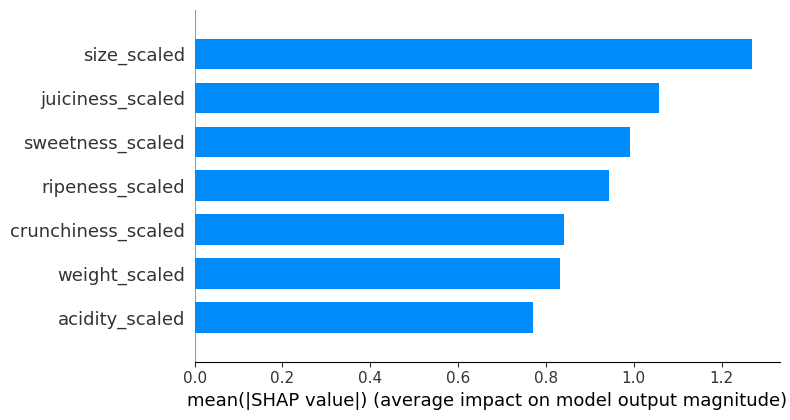

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar")